In [19]:
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def inspect_h5_structure(file_path):
    """
    Inspect the structure of an HDF5 file and print its contents.
    Args:
        file_path (str): Path to the HDF5 file.
    """
    def print_attrs(name, obj):
        print(f"{name}: {type(obj)}")
        if isinstance(obj, h5py.Dataset):
            print(f"  ├─ shape: {obj.shape}, dtype: {obj.dtype}")
        elif isinstance(obj, h5py.Group):
            print(f"  └─ Group with keys: {list(obj.keys())}")
    
    with h5py.File(file_path, 'r') as f:
        print(f"Inspecting file: {file_path}")
        f.visititems(print_attrs)



def load_keypoints(h5_path, image_name):
    with h5py.File(h5_path, 'r') as f:
        keypoints = f[image_name]['keypoints'][()]
    return keypoints

def load_matches(h5_path, name0, name1):
    with h5py.File(h5_path, 'r') as f:
        matches = f[name0][name1][()]  # shape: (N_matches, 2), dtype: int64
    return matches

def draw_matches(image0, image1, kpts0, kpts1, match_indices):
    img0 = cv2.cvtColor(image0, cv2.COLOR_BGR2RGB)
    img1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)

    h1, w1 = img0.shape[:2]
    h2, w2 = img1.shape[:2]
    out_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    out_img[:h1, :w1] = img0
    out_img[:h2, w1:] = img1

    for idx0, idx1 in match_indices:
        pt1 = tuple(np.round(kpts0[idx0]).astype(int))
        pt2 = tuple(np.round(kpts1[idx1]).astype(int) + np.array([w1, 0]))
        cv2.line(out_img, pt1, pt2, color=(0, 255, 0), thickness=1)
        cv2.circle(out_img, pt1, 2, (255, 0, 0), -1)
        cv2.circle(out_img, pt2, 2, (0, 0, 255), -1)

    plt.figure(figsize=(12, 6))
    plt.imshow(out_img)
    plt.axis('off')
    plt.title("Matched Keypoints")
    plt.show()


In [20]:
name0 = '1-1.png'
name1 = '2-1.png'

base_dir = '/home/kshitiz/Documents/Deep_Image_Matching/signature-verification/deep-image-matching/results_superpoint+lightglue_custom_pairs_quality_high/'
features_path = base_dir + 'features.h5'
matches_path = base_dir + 'matches.h5'
img_dir = '/home/kshitiz/Documents/Deep_Image_Matching/signature-verification/deep-image-matching/images/'

image0 = cv2.imread(str(img_dir + name0))
image1 = cv2.imread(str(img_dir + name1))

if image0 is None or image1 is None:
    raise FileNotFoundError("Could not load input images. Check image paths and extensions.")

In [21]:
kpts0 = load_keypoints(features_path, name0)
kpts1 = load_keypoints(features_path, name1)

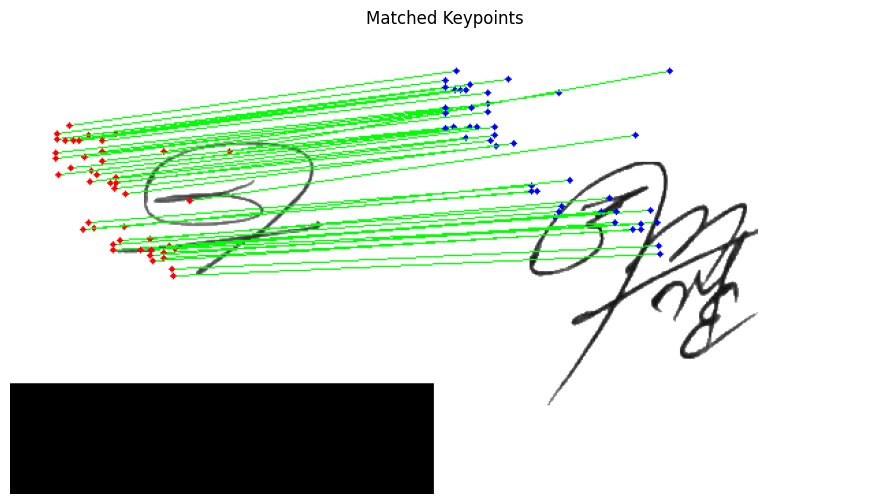

In [22]:
matches = load_matches(matches_path, name0, name1)
draw_matches(image0, image1, kpts0, kpts1, matches)

## Usage

In [23]:
import os
import sys
import subprocess
import h5py
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
import time
from typing import Tuple, Optional, Dict, Any
import shutil

In [26]:
class SignatureMatchingPipeline:
    def __init__(self, 
                 base_dir: str = "/home/kshitiz/Documents/Deep_Image_Matching/signature-verification/deep-image-matching/",
                 images_dir: str = "images",
                 method: str = "superpoint+superglue"):
        """
        Initialize the signature matching pipeline
        
        Args:
            base_dir: Base directory of deep-image-matching
            images_dir: Directory containing images (relative to base_dir)
            method: Matching method to use
        """
        self.base_dir = Path(base_dir)
        self.images_dir = self.base_dir / images_dir
        self.method = method
        self.pairs_file = self.base_dir / "pairs.txt"
        self.results_dir = None
        
        # Ensure directories exist
        self.images_dir.mkdir(exist_ok=True)
        
    def create_pairs_file(self, image1: str, image2: str) -> None:
        """Create pairs.txt file for the two images to match"""
        with open(self.pairs_file, 'w') as f:
            f.write(f"{image1} {image2}\n")
        print(f"Created pairs file: {image1} <-> {image2}")
    
    def run_matching(self, image1: str, image2: str, quality: str = "high") -> Tuple[bool, str]:
        """
        Run the deep image matching command
        Returns:
            Tuple of (success, results_directory_path)
        """
        # Create pairs file
        self.create_pairs_file(image1, image2)
        
        # Construct command
        cmd = [
            "python", "main.py",
            "-d", ".",
            "-p", self.method,
            "-s", "custom_pairs",
            "--pair_file", "pairs.txt",
            "-f"
        ]  
        print(f"Running command: {' '.join(cmd)}")
        print(f"Working directory: {self.base_dir}")
        
        try:
            # Change to base directory and run command
            result = subprocess.run(
                cmd,
                cwd=self.base_dir,
                capture_output=True,
                text=True,
                timeout=300  # 5 minute timeout
            )
            
            if result.returncode == 0:
                print("✓ Matching completed successfully")
                # Find the results directory
                results_pattern = f"results_{self.method.replace('+', '+')}_custom_pairs_quality_{quality}"
                self.results_dir = self.base_dir / results_pattern
                return True, str(self.results_dir)
            else:
                print(f"✗ Matching failed with return code: {result.returncode}")
                print(f"STDOUT: {result.stdout}")
                print(f"STDERR: {result.stderr}")
                return False, ""
                
        except subprocess.TimeoutExpired:
            print("✗ Matching timed out after 5 minutes")
            return False, ""
        except Exception as e:
            print(f"✗ Error running matching: {e}")
            return False, ""
    
    def check_files_exist(self, results_dir: str) -> Dict[str, bool]:
        """Check which output files exist"""
        results_path = Path(results_dir)
        files_to_check = {
            'config.json': results_path / 'config.json',
            'database.db': results_path / 'database.db',
            'features.h5': results_path / 'features.h5',
            'matches.h5': results_path / 'matches.h5',
            'raw_matches.h5': results_path / 'raw_matches.h5',
            'models_dir': results_path / 'models',
            'reconstruction_dir': results_path / 'reconstruction'
        }
        
        existence_map = {}
        for name, path in files_to_check.items():
            existence_map[name] = path.exists()
        
        return existence_map
    
    def load_keypoints(self, h5_path: str, image_name: str) -> Optional[np.ndarray]:
        """Load keypoints from features.h5 file"""
        try:
            with h5py.File(h5_path, 'r') as f:
                if image_name in f:
                    keypoints = f[image_name]['keypoints'][()]
                    return keypoints
                else:
                    print(f"Warning: {image_name} not found in features file")
                    return None
        except Exception as e:
            print(f"Error loading keypoints: {e}")
            return None
    
    def load_matches(self, h5_path: str, name0: str, name1: str) -> Optional[np.ndarray]:
        """Load matches from matches.h5 file"""
        try:
            with h5py.File(h5_path, 'r') as f:
                if name0 in f and name1 in f[name0]:
                    matches = f[name0][name1][()]
                    return matches
                elif name1 in f and name0 in f[name1]:
                    # Try reverse order
                    matches = f[name1][name0][()]
                    # Swap the indices since we're reading in reverse
                    matches = matches[:, [1, 0]]
                    return matches
                else:
                    print(f"Warning: No matches found between {name0} and {name1}")
                    return None
        except Exception as e:
            print(f"Error loading matches: {e}")
            return None
    
    def get_match_statistics(self, results_dir: str, image1: str, image2: str) -> Dict[str, Any]:
        """Get comprehensive match statistics"""
        results_path = Path(results_dir)
        features_path = results_path / 'features.h5'
        matches_path = results_path / 'matches.h5'
        
        stats = {
            'files_exist': self.check_files_exist(results_dir),
            'image1': image1,
            'image2': image2,
            'keypoints1_count': 0,
            'keypoints2_count': 0,
            'matches_count': 0,
            'match_ratio': 0.0,
            'has_matches': False,
            'reconstruction_success': False
        }
        
        # Check if essential files exist
        if not stats['files_exist']['features.h5']:
            stats['error'] = "Features file not found"
            return stats
        
        # Load keypoints
        kpts1 = self.load_keypoints(str(features_path), image1)
        kpts2 = self.load_keypoints(str(features_path), image2)
        
        if kpts1 is not None:
            stats['keypoints1_count'] = len(kpts1)
        if kpts2 is not None:
            stats['keypoints2_count'] = len(kpts2)
        
        # Load matches if file exists
        if stats['files_exist']['matches.h5']:
            matches = self.load_matches(str(matches_path), image1, image2)
            if matches is not None:
                stats['matches_count'] = len(matches)
                stats['has_matches'] = True
                
                # Calculate match ratio
                total_kpts = min(stats['keypoints1_count'], stats['keypoints2_count'])
                if total_kpts > 0:
                    stats['match_ratio'] = stats['matches_count'] / total_kpts
        
        # Check reconstruction success
        stats['reconstruction_success'] = stats['files_exist']['reconstruction_dir']
        
        return stats
    
    def visualize_matches(self, results_dir: str, image1: str, image2: str, 
                         save_path: Optional[str] = None, show_plot: bool = True) -> bool:
        """Visualize matches between two images"""
        results_path = Path(results_dir)
        features_path = results_path / 'features.h5'
        matches_path = results_path / 'matches.h5'
        
        # Load images
        img1_path = self.images_dir / image1
        img2_path = self.images_dir / image2
        
        if not img1_path.exists() or not img2_path.exists():
            print(f"Error: Image files not found")
            return False
        
        image1_cv = cv2.imread(str(img1_path))
        image2_cv = cv2.imread(str(img2_path))
        
        if image1_cv is None or image2_cv is None:
            print("Error: Could not load images")
            return False
        
        # Load keypoints and matches
        kpts1 = self.load_keypoints(str(features_path), image1)
        kpts2 = self.load_keypoints(str(features_path), image2)
        matches = self.load_matches(str(matches_path), image1, image2)
        
        if kpts1 is None or kpts2 is None:
            print("Error: Could not load keypoints")
            return False
        
        # Create visualization
        img1_rgb = cv2.cvtColor(image1_cv, cv2.COLOR_BGR2RGB)
        img2_rgb = cv2.cvtColor(image2_cv, cv2.COLOR_BGR2RGB)
        
        h1, w1 = img1_rgb.shape[:2]
        h2, w2 = img2_rgb.shape[:2]
        
        # Create side-by-side image
        out_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
        out_img[:h1, :w1] = img1_rgb
        out_img[:h2, w1:] = img2_rgb
        
        # Draw keypoints
        for kpt in kpts1:
            cv2.circle(out_img, tuple(np.round(kpt).astype(int)), 2, (255, 0, 0), -1)
        
        for kpt in kpts2:
            cv2.circle(out_img, tuple(np.round(kpt).astype(int) + np.array([w1, 0])), 2, (0, 0, 255), -1)
        
        # Draw matches if they exist
        if matches is not None and len(matches) > 0:
            for idx1, idx2 in matches:
                if idx1 < len(kpts1) and idx2 < len(kpts2):
                    pt1 = tuple(np.round(kpts1[idx1]).astype(int))
                    pt2 = tuple(np.round(kpts2[idx2]).astype(int) + np.array([w1, 0]))
                    cv2.line(out_img, pt1, pt2, (0, 255, 0), 1)
        
        # Plot
        plt.figure(figsize=(15, 8))
        plt.imshow(out_img)
        plt.axis('off')
        
        match_count = len(matches) if matches is not None else 0
        plt.title(f"Signature Matching: {image1} vs {image2}\n"
                 f"Keypoints: {len(kpts1)} vs {len(kpts2)} | Matches: {match_count}")
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Visualization saved to: {save_path}")
        
        if show_plot:
            plt.show()
        
        return True
    
    def print_statistics(self, stats: Dict[str, Any]) -> None:
        """Print comprehensive statistics"""
        print("\n" + "="*60)
        print("SIGNATURE MATCHING ANALYSIS REPORT")
        print("="*60)
        
        print(f"Images: {stats['image1']} <-> {stats['image2']}")
        print(f"Method: {self.method}")
        
        print("\nFile Status:")
        for file_type, exists in stats['files_exist'].items():
            status = "✓" if exists else "✗"
            print(f"  {status} {file_type}")
        
        print(f"\nKeypoint Detection:")
        print(f"  Image 1 ({stats['image1']}): {stats['keypoints1_count']} keypoints")
        print(f"  Image 2 ({stats['image2']}): {stats['keypoints2_count']} keypoints")
        
        print(f"\nMatching Results:")
        print(f"  Total matches: {stats['matches_count']}")
        print(f"  Match ratio: {stats['match_ratio']:.3f}")
        print(f"  Has matches: {'Yes' if stats['has_matches'] else 'No'}")
        print(f"  Reconstruction: {'Success' if stats['reconstruction_success'] else 'Failed'}")
        
        # Similarity assessment
        if stats['matches_count'] > 0:
            if stats['match_ratio'] > 0.1:
                similarity = "HIGH"
            elif stats['match_ratio'] > 0.05:
                similarity = "MEDIUM"
            else:
                similarity = "LOW"
        else:
            similarity = "NONE"
        
        print(f"\nSimilarity Assessment: {similarity}")
        
        if 'error' in stats:
            print(f"\nError: {stats['error']}")
        
        print("="*60)
    
    def analyze_signature_pair(self, image1: str, image2: str, 
                              visualize: bool = True, save_viz: bool = False) -> Dict[str, Any]:
        """
        Complete pipeline to analyze a pair of signature images
        
        Args:
            image1: First image filename
            image2: Second image filename
            visualize: Whether to show visualization
            save_viz: Whether to save visualization
            
        Returns:
            Dictionary containing all analysis results
        """
        print(f"Starting signature matching analysis...")
        print(f"Images: {image1} <-> {image2}")
        
        # Step 1: Run matching
        success, results_dir = self.run_matching(image1, image2)
        
        if not success:
            return {
                'success': False,
                'error': 'Matching command failed',
                'image1': image1,
                'image2': image2
            }
        
        # Step 2: Get statistics
        stats = self.get_match_statistics(results_dir, image1, image2)
        stats['success'] = True
        stats['results_dir'] = results_dir
        
        # Step 3: Print statistics
        self.print_statistics(stats)
        
        # Step 4: Visualize if requested
        if visualize and stats['keypoints1_count'] > 0 and stats['keypoints2_count'] > 0:
            viz_path = None
            if save_viz:
                viz_path = f"signature_match_{image1.split('.')[0]}_{image2.split('.')[0]}.png"
            
            self.visualize_matches(results_dir, image1, image2, viz_path, show_plot=visualize)
        
        return stats


Starting signature matching analysis...
Images: 1-2.png <-> 2-1.png
Created pairs file: 1-2.png <-> 2-1.png
Running command: python main.py -d . -p superpoint+superglue -s custom_pairs --pair_file pairs.txt -f
Working directory: /home/kshitiz/Documents/Deep_Image_Matching/signature-verification/deep-image-matching
✓ Matching completed successfully

SIGNATURE MATCHING ANALYSIS REPORT
Images: 1-2.png <-> 2-1.png
Method: superpoint+superglue

File Status:
  ✓ config.json
  ✓ database.db
  ✓ features.h5
  ✗ matches.h5
  ✓ raw_matches.h5
  ✓ models_dir
  ✗ reconstruction_dir

Keypoint Detection:
  Image 1 (1-2.png): 134 keypoints
  Image 2 (2-1.png): 148 keypoints

Matching Results:
  Total matches: 0
  Match ratio: 0.000
  Has matches: No
  Reconstruction: Failed

Similarity Assessment: NONE
Error loading matches: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/kshitiz/Documents/Deep_Image_Matching/signature-verification/deep-image-matching/results_superpoin

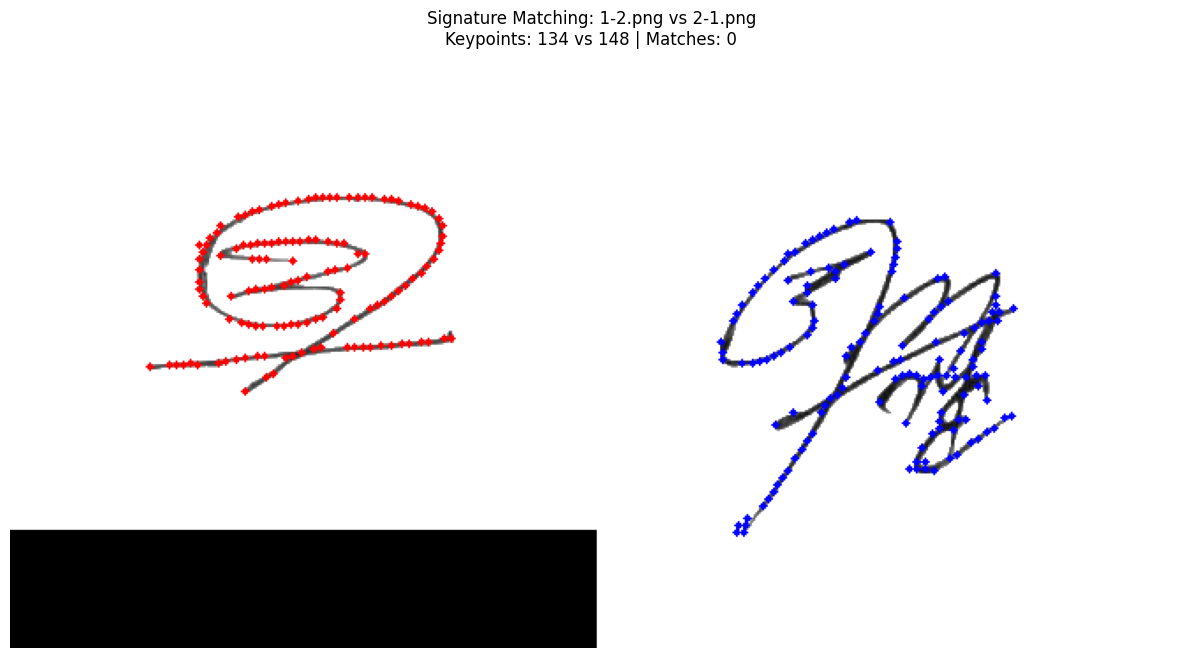

In [27]:
# Initialize pipeline
pipeline = SignatureMatchingPipeline()

# single comparison example
image1, image2 = "1-2.png", "2-1.png"
results = pipeline.analyze_signature_pair( image1=image1, image2=image2,visualize=True,save_viz=False)

# # run multiple comparisons
# pairs_to_compare = [
#     ("1-1.png", "2-1.png"),
#     ("1-1.png", "3-1.png"),
#     ("2-1.png", "3-1.png")
# ]
# for img1, img2 in pairs_to_compare:
#     print(f"\n{'='*80}")
#     results = pipeline.analyze_signature_pair(img1, img2, visualize=True)


## Visualize matching for all images in directory

In [ ]:
import glob
from itertools import combinations
image_directory = 'images'
all_images = glob.glob(os.path.join(image_directory, '*.png'))
all_images_names = [Path(img).name for img in all_images]
pairs_to_compare = list(combinations(all_images_names, 2))
for img1, img2 in pairs_to_compare:
        print(f"\n{'='*80}")
        results = pipeline.analyze_signature_pair(img1, img2, visualize=True)
